# Chorus effect project

In this notebook, we present an implementation of a chorus effect that takes an input signal and outputs the sum of several copies of the input signal, each with a differently varying pitch. First, different pitch shifting techniques will be tested and compared. These thechniques will then be modified to allow time varying shifting.

To begin, let's import the usefull packages, read the original file and plot its time and frequency domain representations.

#### Import packages

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
from IPython.display import Image

#### Read original file

In [2]:
fs, signal = wavfile.read("singing_8000.wav")
fs2, signal2 = wavfile.read("german_speech_8000.wav")
print('Sampling rate :', fs, 'Hz')
print("Original WAV:")
IPython.display.Audio(signal, rate = fs)

Sampling rate : 8000 Hz
Original WAV:


#### Plot time domain waveform

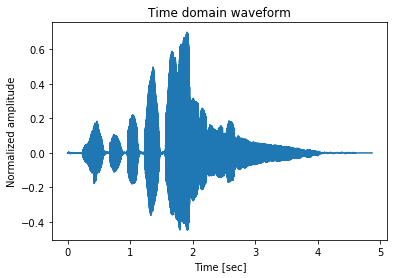

In [3]:
t = np.arange(len(signal))/fs
plt.title('Time domain waveform')
plt.xlabel('Time [sec]')
plt.ylabel('Normalized amplitude')
plt.plot(t,signal/32767.0)
plt.show()

We notice that the signal is composed of multiple consecutives notes, followed by a long sustained note.

#### Plot frequency domain representation

In [4]:
def plot_spec(x, Fs, max_freq=None, do_fft=True):
    C = len(x) / 2  # positive frequencies only
    if max_freq:
        C = int(C * max_freq / float(Fs) * 2) 
    X = np.abs(np.fft.fft(x)[0:C]) if do_fft else x[0:C]
    N = Fs * np.arange(0, C) / len(x);
    plt.plot(N, X) 
    plt.title('Frequency domain')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.plot(t,signal/32767.0)
    plt.show()
    return N, X

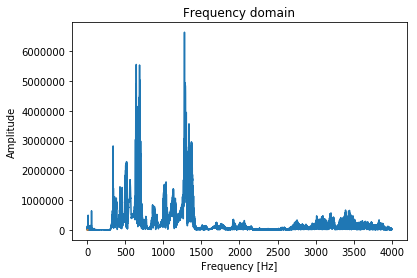

In [5]:
plot_spec(signal, fs, 4000);

#### Plot spectrogram

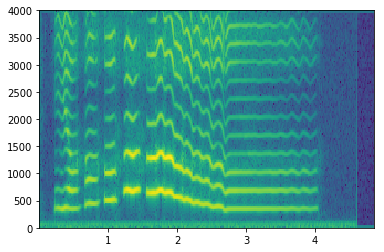

In [6]:
plt.specgram(signal, NFFT=256, Fs =fs);

The previous spectrogram confirms the presence of multiple notes as depicted earlier, and allows us to observe the different harmonic content of the signal.

## Chapter 1 - Constant pitch shifting

A first method simply consists of applying a constant delay in the frequency domain.

In [7]:
def freqDelay(signal, fshift, fs):
    
    shift = int(fshift/fs*len(signal));
    signal_fft = np.fft.rfft(signal);
    signal_fft_rolled = np.roll(signal_fft, shift);
    signal_fft_rolled[0:shift] = 0;
    signal_pitched = np.fft.irfft(signal_fft_rolled)
    
    return signal_pitched

#### Shifted signal

The shifted signal using this simple trick sounds a bit "robotic", as you can hear below

In [8]:
shifted_signal = freqDelay(signal, 200, fs);
IPython.display.Audio(shifted_signal, rate = fs)

#### Sum of pitch-shifted and original signal

The sum of the original signal with the pitch-shifted version creates beats. For this reason, it is not a good method for creating a chorus effect. 

The spectrograms for both signal can be seen below.

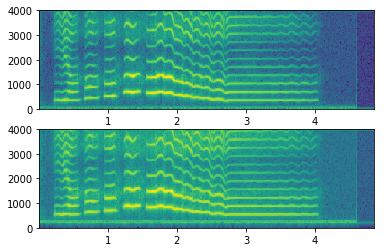

In [9]:
plt.subplot(2, 1, 1)
plt.specgram(signal, NFFT=256, Fs =fs);
plt.subplot(2, 1, 2)
plt.specgram(freqDelay(signal, 200, fs), NFFT=256, Fs =fs);


And here a sum of both original and shifted signals can be heard:

In [10]:
signals_summed = signal[0:len(shifted_signal)] + shifted_signal;
IPython.display.Audio(signals_summed, rate = fs)

## Changing sampling frequency

One way to change the pitch without creating artifacts is to change the sampling frequency of the signal. This results in a pitch shift, but also a time-stretching, which is unwanted for a chorus effect, where the two sounds should have the same duration. Thus, we need to time scale the transformed signal in order for it to have the same duration as the original one.

Here is the result of the signal when we simply change its sampling frequency :

In [11]:
IPython.display.Audio(signal, rate = fs*4)

## Constant pitch shift

In order to pitch shift, we can therefore use a time stretching algorithm which will give a longer or a shorter version of the signal, according to a factor alpha (where alpha = length of time stretched signal divided by length of the original signal). 

In [23]:
def time_stretch(signal,alpha):

    epsilon = 1e-9;
    N=int(2**7) 
    M=int(2**7)
    Rs= int(2**7/8)
    w=np.hanning(2**7)
    Ra = int(Rs / float(alpha))

    hM1 = int(np.floor((M-1)/2.))
    hM2 = int(np.floor(M/2.))

    wscale = sum([i**2 for i in w]) / float(Rs)
    L = signal.size
    L0 = int(signal.size*alpha)


    A = np.fft.fft(w*signal[0:N])
    B = np.fft.fft(w*signal[Ra:Ra+N])
    Freq0 = B/A * abs(B/A)
    plt.plot(abs(Freq0))
    Freq0[Freq0 == 0] = epsilon

    signal = np.append(np.zeros(int(len(w))), signal)
    #signal = np.append(signal,np.zeros(int(len(w))))

    time_stretch_signal = np.zeros(int((signal.size)*alpha + signal.size/Ra * alpha))
    #time_stretch_signal = np.zeros(int((signal.size)*alpha))

    p, pp = 0, 0
    pend = signal.size - (Rs+N)
    Yold = epsilon

    i = 0
    while p <= pend:
        i += 1
        # Spectra of two consecutive windows    
        a = w*signal[p+Rs:p+Rs+N]
        Xs = np.fft.fft(w*signal[p:p+N])
        Xt = np.fft.fft(w*signal[p+Rs:p+Rs+N])

        # Prohibit dividing by zero
        Xs[Xs == 0] = epsilon
        Xt[Xt == 0] = epsilon

        # inverse FFT and overlap-add
        if p > 0 :
            Y = Xt * (Yold / Xs) / abs(Yold / Xs)
        else:
            Y = Xt * Freq0

        Yold = Y
        Yold[Yold == 0] = epsilon

        time_stretch_signal[pp:pp+N] = np.add(time_stretch_signal[pp:pp+N], w*np.fft.ifft(Y), out=time_stretch_signal[pp:pp+N], casting="unsafe")

        p = int(p+Ra)		# analysis hop
        pp += Rs			# synthesis hop

    time_stretch_signal = time_stretch_signal / wscale    
    # retrieve input signal perfectly
    #signal = np.delete(signal, range(2000))

    time_stretch_signal = np.delete(time_stretch_signal, range(Rs))
    time_stretch_signal = np.delete(time_stretch_signal, range(L0, time_stretch_signal.size))
    #time_stretch_signal = np.delete(time_stretch_signal, range(len(time_stretch_signal)-int(alpha*len(w)),len(time_stretch_signal)))
    return time_stretch_signal


Here is what we obtain when time-stretching the original signal.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: ComplexWarning: Casting complex values to real discards the imaginary part


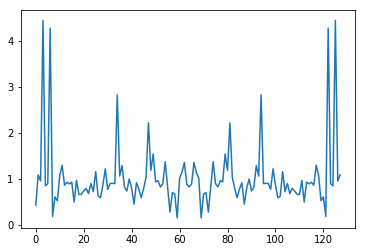

In [24]:
alpha = 2
pitched_signal = time_stretch(signal,alpha)
IPython.display.Audio(pitched_signal, rate = fs)

To obtain a constant pitch shift, we only need to resample the time stretched signal by a factor alpha:

In [14]:
alpha = 2
pitched_signal = time_stretch(signal,alpha)
pitched_signal_resample = sp.signal.resample(pitched_signal,len(signal))
IPython.display.Audio(pitched_signal_resample, rate = fs)

[0.0, 3.742893201806772e-07, 5.981303774876999e-06, 3.021863345057712e-05, 9.523332728817402e-05, 0.00023165045777525788, 0.00047819702448422934, 0.0008812250628992904, 0.0014941388637204308, 0.0023767321980046768, 0.0035944423752898797, 0.005217528826003178, 0.007320184687407214, 0.00997959057625311, 0.013274920344184564, 0.017286309127661274, 0.02209379441758455, 0.02777624118075975, 0.03441026226271185, 0.04206914538714822, 0.05082179804060289, 0.06073172139166548, 0.07185602414397319, 0.0842444868631848, 0.09793868685390333, 0.11297119309742977, 0.12936484010078383, 0.14713208875801115, 0.1662744814936927, 0.18678219805385507, 0.2086337173399691, 0.23179558965685043, 0.2562223226750461, 0.28185638330315427, 0.3086283165362569, 0.33645698120430234, 0.36524990140001135, 0.39490373123090866, 0.42530482942548986, 0.4563299392402644, 0.48784696807306976, 0.5197158601988549, 0.5517895551167814, 0.5839150231411183, 0.6159343690914187, 0.6476859942475203, 0.6790058061388276, 0.709728465240

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: ComplexWarning: Casting complex values to real discards the imaginary part


Here we go! We have a clean, pitched version of our original signal. The last step is to make this pitch vary in time.

## Time varying pitch

In order to get a time-varying pitch, we send different windowed frames with different values of alpha to the time-stretching algorithm, resample them, and sum them in order to recover the pitched-varying signal. The diagram and corresponding code can be seen below:

![title](timevarying.png)

In [189]:
def time_varying_pitch(signal, fs, intensity, rate):
    N = int(rate*len(signal)/fs)
    alpha_max = 1.1
    overlap = 400
    safety = 200
    effective_window = 1000
    length_window = effective_window + overlap + 2*safety
    n = int(len(signal)/effective_window)
    fade_in = np.linspace(0,1,overlap)
    fade_out = np.linspace(1,0,overlap)
    time_stretch_resample = []
    window_resample = []
    
    for i in range(n):
        alpha = 1 + intensity*np.sin(2*N*np.pi*i/n)
        
        low_index = i*effective_window
        high_index = i*effective_window + length_window
        
        time_stretched_window = time_stretch(signal[low_index:high_index],alpha)

        # delete safety margins
        time_stretched_window = np.delete(time_stretched_window,range(len(time_stretched_window)-int(safety*alpha),len(time_stretched_window)))
        time_stretched_window = np.delete(time_stretched_window,range(0,int(safety*alpha)))
            
        
        #pitch, #append, #overlap
        window_resample = sp.signal.resample(time_stretched_window,effective_window+overlap)
        if i==0:
            time_stretch_resample = window_resample
            #fade out
            time_stretch_resample[effective_window:effective_window+overlap] *= fade_out

        if i>0:
        # fade in - fade out
            window_resample[0:overlap] *= fade_in
            print(len(window_resample))
            window_resample[effective_window:effective_window+overlap] *= fade_out
            print(len(window_resample))
            time_stretch_resample[len(time_stretch_resample)-overlap:len(time_stretch_resample)] += window_resample[0:overlap]
            print(len(time_stretch_resample))
            time_stretch_resample = np.append(time_stretch_resample,window_resample[overlap:])
            print(len(time_stretch_resample))
        #time_stretch_signal = time_stretch(signal[int(np.floor((i)*len(signal)/n)) : int(np.floor((i+1)*len(signal)/n))],alpha)
        #time_stretch_signal = signal[int(np.floor((i)*len(signal)/n)):int(np.floor((i+1)*len(signal)/n))]
        #time_stretch_resample = np.append(time_stretch_resample, rescale(time_stretch_signal, 1/alpha))
    time_stretch_resample = np.append(signal[0:safety-64],time_stretch_resample)
    return time_stretch_resample
    

Let's see what we get when we sum the original signal and a signal whose pitch varies at 1Hz, with a pitch variation of ±2%. 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: ComplexWarning: Casting complex values to real discards the imaginary part


1400
1400
1400
2400
1400
1400
2400
3400
1400
1400
3400
4400
1400
1400
4400
5400
1400
1400
5400
6400
1400
1400
6400
7400
1400
1400
7400
8400
1400
1400
8400
9400
1400
1400
9400
10400
1400
1400
10400
11400
1400
1400
11400
12400
1400
1400
12400
13400
1400
1400
13400
14400
1400
1400
14400
15400
1400
1400
15400
16400
1400
1400
16400
17400
1400
1400
17400
18400
1400
1400
18400
19400
1400
1400
19400
20400
1400
1400
20400
21400
1400
1400
21400
22400
1400
1400
22400
23400
1400
1400
23400
24400
1400
1400
24400
25400
1400
1400
25400
26400
1400
1400
26400
27400
1400
1400
27400
28400
1400
1400
28400
29400
1400
1400
29400
30400
1400
1400
30400
31400
1400
1400
31400
32400
1400
1400
32400
33400
1400
1400
33400
34400
1400
1400
34400
35400
1400
1400
35400
36400
1400
1400
36400
37400
1400
1400
37400
38400


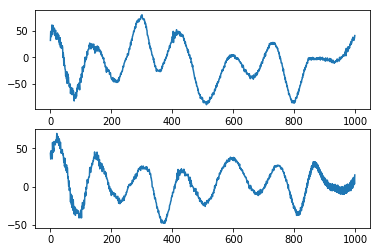

In [190]:
chorus_signal = time_varying_pitch(signal,fs,0.04,1)

idx = 400
plt.subplot(2,1,2)
plt.plot(chorus_signal[idx:idx+1000])
plt.subplot(2,1,1)
plt.plot(signal[idx:idx+1000])
IPython.display.Audio(signal[0:min(len(chorus_signal),len(signal))]+chorus_signal[0:min(len(chorus_signal),len(signal))], rate = fs)
#IPython.display.Audio(signal, rate = fs)



## Chorus Effect

In [191]:
def chorus_effect(signal, fs, intensity1, intensity2, rate1, rate2, wet):
    chorus_signal_1 = time_varying_pitch(signal,fs,intensity1,rate1)
    chorus_signal_2 = time_varying_pitch(signal,fs,intensity2,rate2)
    
    #return 1/2*wet*chorus_signal_1[0:min(len(chorus_signal_1),len(signal))]+1/2*wet*chorus_signal_2[0:min(len(chorus_signal_1),len(signal))]+ (1-wet)*signal[0:min(len(chorus_signal_1),len(signal))]
    return 1/2*wet*chorus_signal_1+1/2*wet*chorus_signal_2+ (1-wet)*signal

In [192]:
chorus = chorus_effect(signal,fs,0.01,0.01,1,1,0.5)
IPython.display.Audio(chorus,rate = fs)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: ComplexWarning: Casting complex values to real discards the imaginary part


1400
1400
1400
2400
1400
1400
2400
3400
1400
1400
3400
4400
1400
1400
4400
5400
1400
1400
5400
6400
1400
1400
6400
7400
1400
1400
7400
8400
1400
1400
8400
9400
1400
1400
9400
10400
1400
1400
10400
11400
1400
1400
11400
12400
1400
1400
12400
13400
1400
1400
13400
14400
1400
1400
14400
15400
1400
1400
15400
16400
1400
1400
16400
17400
1400
1400
17400
18400
1400
1400
18400
19400
1400
1400
19400
20400
1400
1400
20400
21400
1400
1400
21400
22400
1400
1400
22400
23400
1400
1400
23400
24400
1400
1400
24400
25400
1400
1400
25400
26400
1400
1400
26400
27400
1400
1400
27400
28400
1400
1400
28400
29400
1400
1400
29400
30400
1400
1400
30400
31400
1400
1400
31400
32400
1400
1400
32400
33400
1400
1400
33400
34400
1400
1400
34400
35400
1400
1400
35400
36400
1400
1400
36400
37400
1400
1400
37400
38400
1400
1400
1400
2400
1400
1400
2400
3400
1400
1400
3400
4400
1400
1400
4400
5400
1400
1400
5400
6400
1400
1400
6400
7400
1400
1400
7400
8400
1400
1400
8400
9400
1400
1400
9400
10400
1400
1400
10400
11400


ValueError: operands could not be broadcast together with shapes (38536,) (38979,) 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: ComplexWarning: Casting complex values to real discards the imaginary part


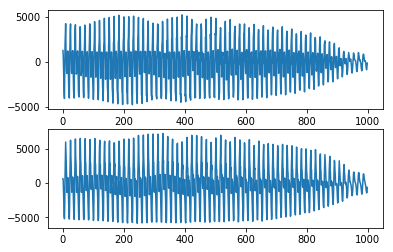

In [188]:

d = 96
d2 = 0
idx = 8000
plt.subplot(2,1,1)
plt.plot(time_stretch(signal,1)[idx+d:idx+d+1000])
plt.subplot(2,1,2)
plt.plot(signal[idx:idx+1000])

In [167]:
fs, signal = wavfile.read("singing_8000.wav")

chorus1 = time_varying_pitch(signal,0.01,1)
mix = 1
plt.subplot(2, 1, 1)
plt.plot(signal[0:int(len(signal)/20*2+1000)])

plt.subplot(2, 1, 2)
plt.plot(chorus1[0:int(len(signal)/20*2+1000)])

#IPython.display.Audio((1-mix)*signal[0:min(len(signal),len(chorus1))]+mix*chorus1[0:min(len(signal),len(chorus1))], rate = fs*1)
IPython.display.Audio((1-mix)*signal[0:min(len(signal),len(chorus1))]+mix*chorus1[0:min(len(signal),len(chorus1))], rate = fs*1)


TypeError: time_varying_pitch() missing 1 required positional argument: 'rate'

In [168]:
def time_varying_pitch_corrected(signal, intensity, rate):
    N = int(rate*len(signal)/fs)
    n = 20
    w = np.hanning(2**8)
    time_stretch_resample = []
    for i in range(n):
        alpha = 1 + intensity*np.sin(2*N*np.pi*i/n)
        alpha = 1
        time_stretch_signal = time_stretch(signal[int((i*len(signal)/n)) : int(((i*len(signal)/n))+len(signal)/n)],alpha)
        w[w<1e-2] = 1e-2;
        #print(time_stretch_signal.size)
        #print(signal.size/n)
        if(i == 2):
            plt.subplot(6, 1, 1)
            plt.plot(signal[int((i*len(signal)/n)) : int(((i*len(signal)/n))+len(signal)/n)])

            plt.subplot(6, 1, 2)
            plt.plot(time_stretch_signal)
                        
        #time_stretch_signal[0:int(len(w)/2)] /= w[0:int(len(w)/2)]
        #time_stretch_signal[len(time_stretch_signal)-int(len(w)/2-1):len(time_stretch_signal)]/= w[int(len(w)/2+1):int(len(w))]

        #if(i == 2):
            #plt.subplot(6,1,5)
            #plt.plot(time_stretch_signal[0:int(len(w)/2)] )

        #time_stretch_signal[len(time_stretch_signal)-int(len(w)/2-1):len(time_stretch_signal)] = 1000
        #time_stretch_signal[0:int(len(w)/2)] = -1000
        #time_stretch_signal = signal[int(np.floor((i)*len(signal)/n)):int(np.floor((i+1)*len(signal)/n))]

        time_stretch_resample = np.append(time_stretch_resample, rescale(time_stretch_signal, 1/alpha))

    return time_stretch_resample
    

In [15]:
def rescale(arr,factor):
    n = len(arr)
    return np.interp(np.linspace(0,n,factor*n+1),np.arange(n), arr)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


38999
38979


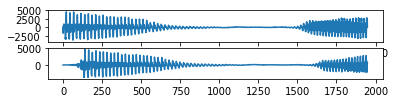

In [24]:
fs, signal = wavfile.read("singing_8000.wav")

chorus1 = time_varying_pitch_corrected(signal,0.01,1)
pitched = time_stretch(signal,2)
mix = 0.5
#plt.subplot(2, 1, 1)
#plt.plot(signal[0:int(len(signal)/20*2+1000)])

#plt.subplot(2, 1, 2)
#plt.plot(chorus1[0:int(len(signal)/20*2+1000)])
print(len(chorus1))
print(len(signal))
b = (1-mix)*signal[0:min(len(signal),len(chorus1))]+mix*chorus1[0:min(len(signal),len(chorus1))]
pitched = rescale(pitched, 1/2)
#plt.subplot(2,1,1)
#plt.plot(signal)
#plt.subplot(2,1,2)
#plt.plot(chorus1)

IPython.display.Audio(chorus1, rate = fs)




In [19]:
def time_varying_pitch_overlap(signal, intensity, rate):
    N = int(rate*len(signal)/fs)
    pck = 2560
    n = len(signal)/pck
    for i in range(n):
        alpha = 1 + intensity*np.sin(2*N*np.pi*i/n)
        time_stretch_signal = time_stretch(signal[int(np.floor((i)*len(signal)/n)) : int(np.floor((i+1)*len(signal)/n))],alpha)
        #time_stretch_signal = signal[int(np.floor((i)*len(signal)/n)):int(np.floor((i+1)*len(signal)/n))]
        time_stretch_resample = np.append(time_stretch_resample, rescale(time_stretch_signal, 1/alpha))
        
    return time_stretch_resample


#### Resampling (from Real-Time Voice Transformers jupyter notebook)

In [25]:
def subsample(x, t):
    n = int(t)
    a = 1.0 - (t - n)
    try:
        return a * x[n] + (1 - a) * x[n + 1] 
    except IndexError:
        try:
            return a * x[n]
        except IndexError:
            return 0

def resample(x, f):
    # length of the output signal after resampling
    n_out = int(np.floor(len(x) / f))
    y = np.zeros(n_out)
    for n in range(0, n_out):
        y[n] = subsample(x, float(n) * f)
    return y

In [18]:
def time_stretch_mod(signal,alpha):

    epsilon = 1e-9;
    N=int(2**8) 
    M=int(2**8)
    Rs= int(2**8/8)
    w=np.hanning(2**8)
    Ra = int(Rs / float(alpha))

    hM1 = int(np.floor((M-1)/2.))
    hM2 = int(np.floor(M/2.))

    wscale = sum([i**2 for i in w]) / float(Rs)
    L = signal.size
    L0 = int(signal.size*alpha)


    A = np.fft.fft(w*signal[0:N])
    B = np.fft.fft(w*signal[Ra:Ra+N])
    Freq0 = B/A * abs(B/A)
    Freq0[Freq0 == 0] = epsilon

    signal = np.append(np.zeros(int(len(w))), signal)
    #signal = np.append(signal,np.zeros(int(len(w))))

    time_stretch_signal = np.zeros(int((signal.size)*alpha + signal.size/Ra * alpha))
    #time_stretch_signal = np.zeros(int((signal.size)*alpha))

    p, pp = 0, 0
    pend = signal.size - (Rs+N)
    Yold = epsilon

    i = 0
    while p <= pend:
        i += 1
        # Spectra of two consecutive windows    
        a = w*signal[p+Rs:p+Rs+N]
        Xs = np.fft.fft(w*signal[p:p+N])
        Xt = np.fft.fft(w*signal[p+Rs:p+Rs+N])

        # Prohibit dividing by zero
        Xs[Xs == 0] = epsilon
        Xt[Xt == 0] = epsilon

        # inverse FFT and overlap-add
        if p > 0 :
            Y = Xt * (Yold / Xs) / abs(Yold / Xs)
        else:
            Y = Xt * Freq0

        Yold = Y
        Yold[Yold == 0] = epsilon

        time_stretch_signal[pp:pp+N] = np.add(time_stretch_signal[pp:pp+N], w*np.fft.ifft(Y), out=time_stretch_signal[pp:pp+N], casting="unsafe")

        p = int(p+Ra)		# analysis hop
        pp += Rs			# synthesis hop

    time_stretch_signal = time_stretch_signal / wscale        
    #time_stretch_signal = np.delete(time_stretch_signal, range(int(alpha*160)))
    time_stretch_signal = np.delete(time_stretch_signal, range(L0, time_stretch_signal.size))
    #time_stretch_signal = np.delete(time_stretch_signal, range(len(time_stretch_signal)-alpha*352,len(time_stretch_signal)))
    
    return time_stretch_signal


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: ComplexWarning: Casting complex values to real discards the imaginary part


38979
38979
38979
42876
[0 1]


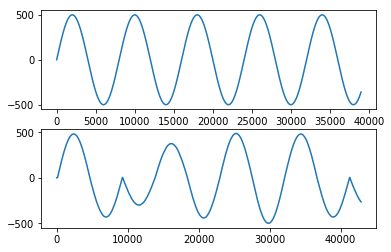

In [17]:
t = np.arange(len(signal))
signal_ones = 500*np.sin(2*np.pi*t/fs)
time_stretch_signal_ones = time_stretch(signal_ones,1.1)
print(signal_ones.size)
print(signal.size)
#plt.stem(time_stretch_signal_ones[len(time_stretch_signal_ones)-100:len(time_stretch_signal_ones)])


plt.subplot(2,1,1)
plt.plot(signal_ones)
plt.subplot(2,1,2)
plt.plot(time_stretch_signal_ones)

print(len(signal))
print(len(time_stretch_signal_ones))
print(t[0:2])

In [26]:
def ms2smp(ms, Fs):
    return int(float(Fs) * float(ms) / 1000.0)

In [27]:
def win_taper(N, a):
    R = int(N * a / 2)
    r = np.arange(0, R) / float(R)
    win = np.r_[r, np.ones(N - 2*R), r[::-1]]
    stride = N - R - 1
    return win, stride

#### DFT-based pitch shift

In [28]:
def DFT_rescale(x, f):
    X = np.fft.fft(x)
    # separate even and odd lengths
    parity = (len(X) % 2 == 0)
    N = int(len(X) / 2 + 1 if parity else (len(X) + 1) / 2)
    Y = np.zeros(N, dtype=np.complex)
    # work only in the first half of the DFT vector since input is real
    for n in range(0, N):
        # accumulate original frequency bins into rescaled bins
        ix = int(n * f)
        if ix < N:
            Y[ix] += X[n]
    # now rebuild a Hermitian-symmetric DFT
    Y = np.r_[Y, np.conj(Y[-2:0:-1])] if parity else np.r_[Y, np.conj(Y[-1:0:-1])]
    return np.real(np.fft.ifft(Y))

def DFT_pshift(x, f, G, overlap=0):
    N = len(x)
    y = np.zeros(N)
    win, stride = win_taper(G, overlap)
    #stride = int(0.5*G)
    #win = np.hanning(G)
    for n in range(0, len(x) - G, stride):
        w = DFT_rescale(x[n:n+G] * win, f)
        y[n:n+G] += w * win
    return y

In [29]:
IPython.display.Audio(DFT_pshift(signal, 0.9, ms2smp(100, fs),0.4), rate=fs)

In [ ]:
y = DFT_pshift(signal, 0.8, ms2smp(100, fs),0.4)
plt.plot(y)

In [ ]:
plot_spec(, fs)

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [ ]:
def modulation(signal, amp, f, dry, wet):
    delay = amp*np.sin(2*np.pi*f*t);
    
    modulated = signal.copy()
    # Delay designer
    for i in range(len(signal)):
        k = int(i - delay[i])
        if k >= 0 and k < len(signal):
            modulated[i] = signal[i] * dry + signal[k] * wet
    
    return modulated

#### Apply modulated delay

In [ ]:
def modulated_delay(data, modwave, dry, wet):
    ''' Use LFO "modwave" as a delay modulator (no feedback)
    '''

    out = data.copy()
    for i in range(len(data)):
        index = int(i - modwave[i])
        if index >= 0 and index < len(data):
            out[i] = data[i] * dry + data[index] * wet
    return out

#### Granular Synthesis-based pitch shift

In [ ]:
def double_len2(x, G):
    N = len(x)
    y = np.zeros(2 * N)
    overlap = 0.3
    win, stride = win_taper(G, overlap)
    ix = 0
    for n in range(0, len(x) - G, G):
        for k in [0, 1]:
            y[ix:ix+G] += x[n:n+G] * win
            ix += stride
    return y

In [ ]:
def GS_pshift(x, f, G, overlap=0.2):
    N = len(x)
    y = np.zeros(N)
    # size of input buffer given grain size and resampling factor
    igs = int(G * f + 0.5)
    win, stride = win_taper(G, overlap)
    for n in range(0, len(x) - max(igs, G), stride):
        w = resample(x[n:n+igs], f)
        y[n:n+G] += w * win
    return y

In [ ]:
IPython.display.Audio(GS_pshift(signal, 0.9, ms2smp(40, fs), .2), rate=fs)

In [ ]:
shift = 100
vshift = 100*np.sin(2*np.pi*10*t)
signal_fft = np.fft.rfft(signal);
signal_fft_rolled = np.roll(signal_fft, shift);
signal_fft_rolled[0:shift] = 0;
signal_pitched = np.fft.irfft(signal_fft_rolled)

test = []
for i in range(len(signal)):
    index = i - int(vshift[i])
    #print(i)
    #print(vshift[i])
    #print(index)
    if index >= 0 and index < len(signal):
        test.append(signal[i] * 0.5 + signal[index] * 0.5)

signal_chor = np.roll(signal_pitched, shift)
signal_chor[0:shift] = 0;

shift2 = 100
print(len(signal))
signal_fft = np.fft.rfft(signal);
signal_fft_rolled = np.roll(signal_fft, shift2);
signal_fft_rolled[0:shift2] = 0;
signal_chor2 = np.fft.irfft(signal_fft_rolled)

modwave = 10*np.sin(2*np.pi*10*t);
#print(len(modwave))
signal_tdelayed = modulated_delay(signal, modwave, 0.5, 0.5)
#signal_ftdelayed = modulated_delay(signal_tdelayed, 100000*np.ones(len(t)), 0.5, 0.5)
#signal_ftdelayed = np.fft.irfft(modulated_delay(abs(np.fft.rfft(signal)), 100*np.ones(len(t)), 0.5, 0.5))

#plt.plot(signal_tdelayed)
plt.specgram(signal_chor2, NFFT=256, Fs =fs);

#plt.specgram(0.4* signal[0:len(signal_chor)] + 0.3* signal_chor + 0.3* signal_chor2, NFFT=256, Fs =fs);
#IPython.display.Audio(test+signal[0:len(test)], rate = fs)
#IPython.display.Audio(0.5*signal[0:len(signal_chor2)] + 0.5*signal_chor2 , rate = fs)
IPython.display.Audio(0.5*signal[0:len(signal_tdelayed)] + 0.5*signal_tdelayed , rate = fs)


In [ ]:
# generate a window with 40% taper (20% left and 20% right)
win = np.hanning(100)
# align two windows using the given stride and sum them 
win1 = np.r_[win, np.zeros(50)]
win2 = np.r_[np.zeros(50), win]
plt.plot(win1);
plt.plot(win2);
# if the windows are properly aligned, the tapered areas compensate
plt.plot(win1 + win2);
plt.gca().set_ylim([0, 1.1]);